### ⭐ MLP는 딥러닝이기에, 코랩 pro에서 진행됨!

최종 선정된 컬럼들을 가지고 머신러닝 뿐만 아니라, 딥러닝인 MLP도 진행해봤음.

코랩 코드 공유

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
import operator
import math
import warnings
import openpyxl
import random
warnings.filterwarnings("ignore")
from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
import tensorflow as tf
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import sys

# Google Colab 환경에서 실행 중인지 확인
if 'google.colab' in sys.modules:
    # debconf를 Noninteractive 모드로 설정
    !echo 'debconf debconf/frontend select Noninteractive' | \
    debconf-set-selections

    # fonts-nanum 패키지를 설치
    !sudo apt-get -qq -y install fonts-nanum

    # Matplotlib의 폰트 매니저 가져오기
    import matplotlib.font_manager as fm

    # 나눔 폰트의 시스템 경로 찾기
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])

    # 찾은 각 나눔 폰트를 Matplotlib 폰트 매니저에 추가
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

In [ ]:
plt.rc('font', family='NanumBarunGothic', size=11)
plt.rcParams['axes.unicode_minus'] = True
print(plt.rcParams['font.family'], plt.rcParams['font.size'])   # 폰트확인
# df.head() 이런거 했을 때, 컬럼이 생략되지 않고, 모든 컬럼 뜨게
pd.set_option('display.max_columns', None)
# 지수 표기법 대신에 소수점으로 표시하는코드
pd.options.display.float_format = '{:.2f}'.format
# 값 길이 제한 X
pd.set_option('display.max_colwidth', None) # 값 길이 제한 없음

In [ ]:
datapath_df = '/content/drive/MyDrive/Colab Notebooks/data/full_data/TPS_cancel_data_Final.csv'
df = pd.read_csv(datapath_df)

In [ ]:
df

MLP 학습

In [ ]:
train = df[df['p_mt'].isin([2,3,4,5,6,7,8,9])]
val = df[df['p_mt'] == 10]
test = df[df['p_mt'] == 11]

In [ ]:
d_cols = ['sha2_hash','p_mt']

train.drop(d_cols, axis=1, inplace=True)
val.drop(d_cols, axis=1, inplace=True)
test.drop(d_cols, axis=1, inplace=True)

display(train, val, test)

In [ ]:
from sklearn.utils import resample

# 데이터 분리
df_Y = train[train['churn'] == 'Y']
df_N = train[train['churn'] == 'N']

# Y의 데이터 개수와 비율에 따른 N의 샘플 개수 계산
y_count = len(df_Y)  # Y 데이터 개수
n_count_target = int((6 / 4) * y_count)  # 7:3 비율로 N 데이터 개수 계산

# N 데이터를 랜덤 샘플링
df_N_downsampled = resample(
    df_N,
    replace=False,  # 복원 샘플링 하지 않음
    n_samples=n_count_target,  # 목표 샘플 개수
    random_state=42  # 재현성을 위한 시드
)

# 언더샘플링된 데이터 결합
train_balanced = pd.concat([df_Y, df_N_downsampled])

# 결과 섞기 (선택 사항)
train_balanced = train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# 결과 확인
print("최종 데이터 분포:")
print(train_balanced['churn'].value_counts())

train = train_balanced

In [ ]:
from sklearn.preprocessing import LabelEncoder

# 데이터 병합
combined = pd.concat([train, val, test], keys=['train', 'val', 'test'])

# 레이블 인코딩 수행
label_encoders = {}
for column in combined.select_dtypes(include=['object']).columns:  # object 타입 컬럼만 선택
    le = LabelEncoder()
    combined[column] = le.fit_transform(combined[column])  # 레이블 인코딩 수행
    label_encoders[column] = le  # 각 컬럼의 LabelEncoder 저장

# 데이터 분리
train = combined.xs('train')  # train 데이터 분리
val = combined.xs('val')      # val 데이터 분리
test = combined.xs('test')    # test 데이터 분리

In [ ]:
display(train, val, test)

In [ ]:
# 정규화
from sklearn.preprocessing import MinMaxScaler

data_to_scale = train.drop(columns=['churn']).columns

scaler = MinMaxScaler()
train[data_to_scale] = scaler.fit_transform(train[data_to_scale])
val[data_to_scale] = scaler.transform(val[data_to_scale])
test[data_to_scale] = scaler.transform(test[data_to_scale])

In [ ]:
import tensorflow as tf

#GPU 확인

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU Device: ", tf.config.list_physical_devices('GPU'))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.mixed_precision import set_global_policy
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# GPU 확인 및 혼합 정밀도 설정
# -----------------------------------------------------------
# GPU 활성화 확인
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU Device: ", tf.config.list_physical_devices('GPU'))

# 혼합 정밀도 설정 (A100 GPU 최적화)
set_global_policy('mixed_float16')  # 혼합 정밀도 활성화로 연산 속도 향상

# -----------------------------------------------------------
# 데이터 준비
# -----------------------------------------------------------
# 독립 변수와 타겟 변수 분리
X_train, y_train = train.drop(columns=['churn']), train['churn']
X_val, y_val = val.drop(columns=['churn']), val['churn']
X_test, y_test = test.drop(columns=['churn']), test['churn']

# -----------------------------------------------------------
# MLP 모델 정의
# -----------------------------------------------------------
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),  # 입력 크기
    Dropout(0.4),  # 과적합 방지
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # 이진 분류를 위한 sigmoid 출력층
])

# 모델 컴파일
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # 이진 분류 손실 함수
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]  # 정확도와 AUC
)

# -----------------------------------------------------------
# 학습
# -----------------------------------------------------------
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # 10번의 에포크 동안 성능 개선 없으면 중단
    restore_best_weights=True  # 가장 좋은 모델 복원
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # 최대 100 에포크
    batch_size=256,  # GPU 활용을 위한 큰 배치 크기
    callbacks=[early_stopping],  # 조기 종료
    verbose=1
)

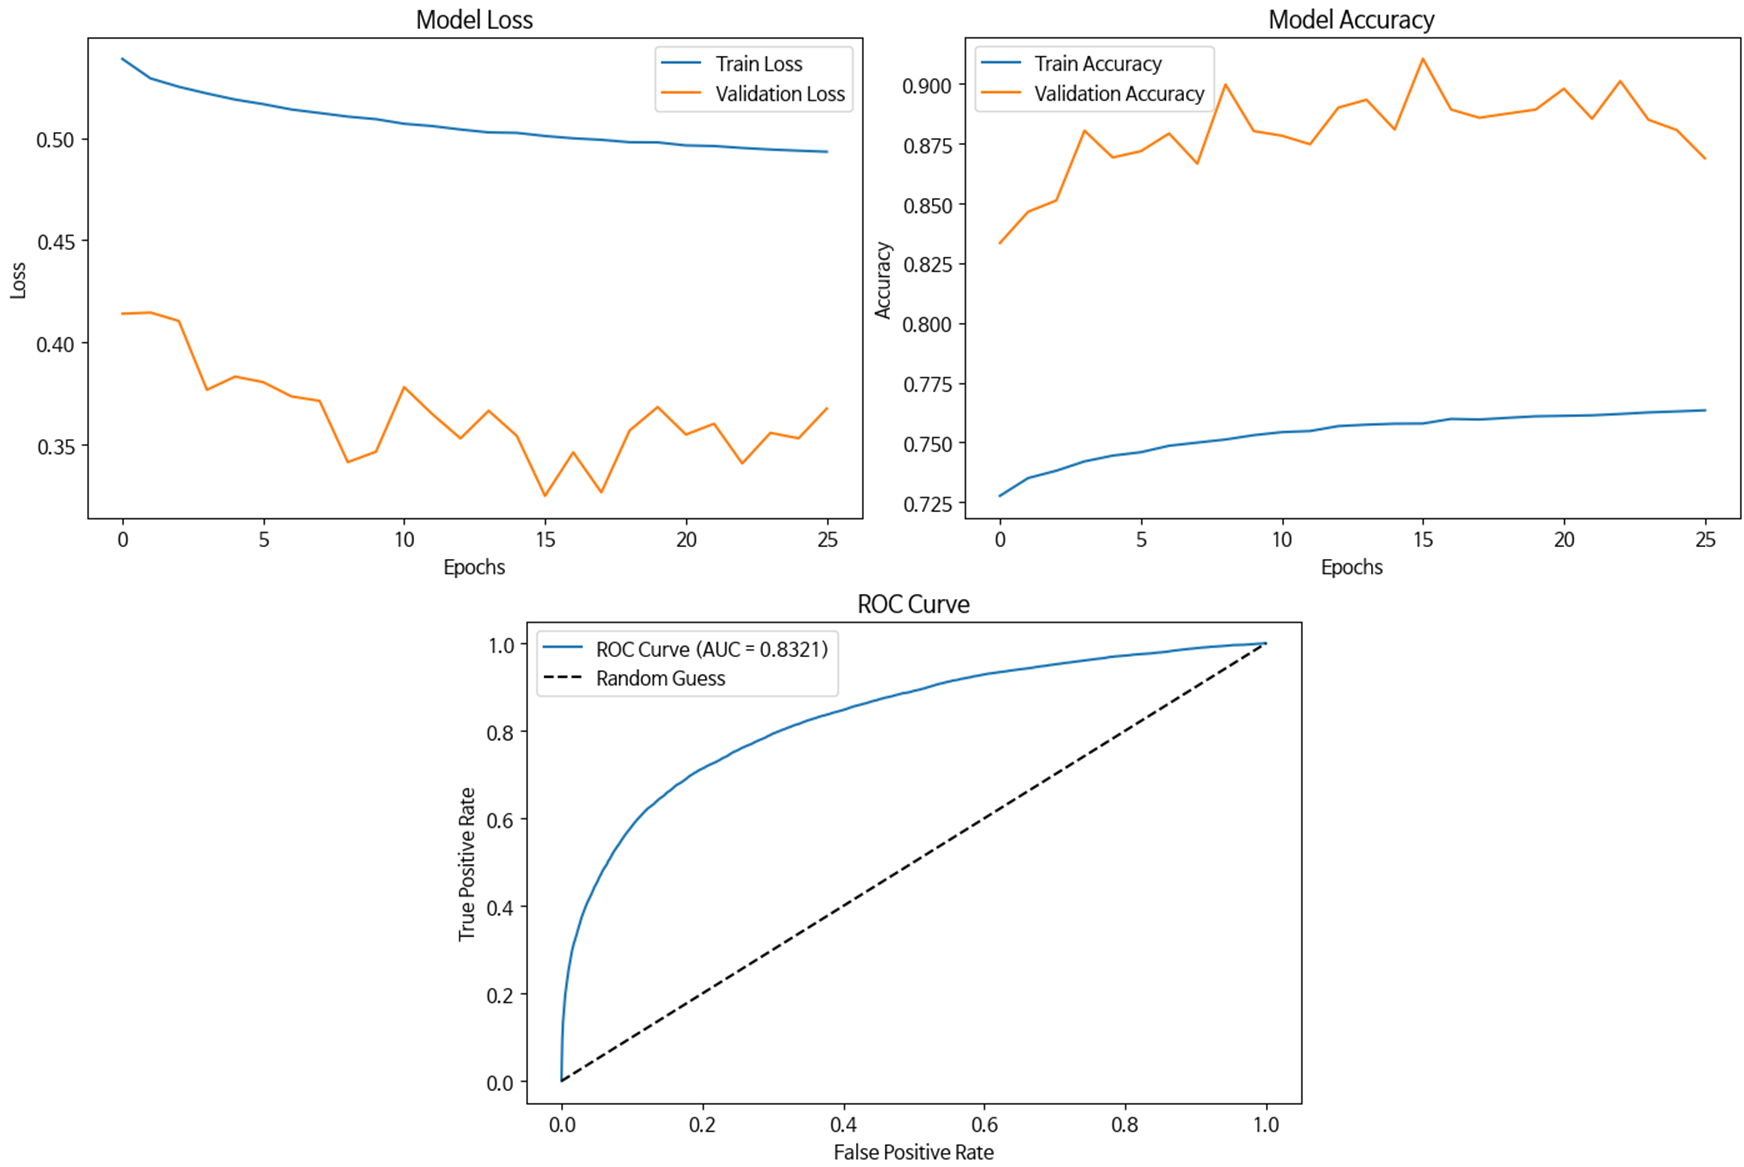
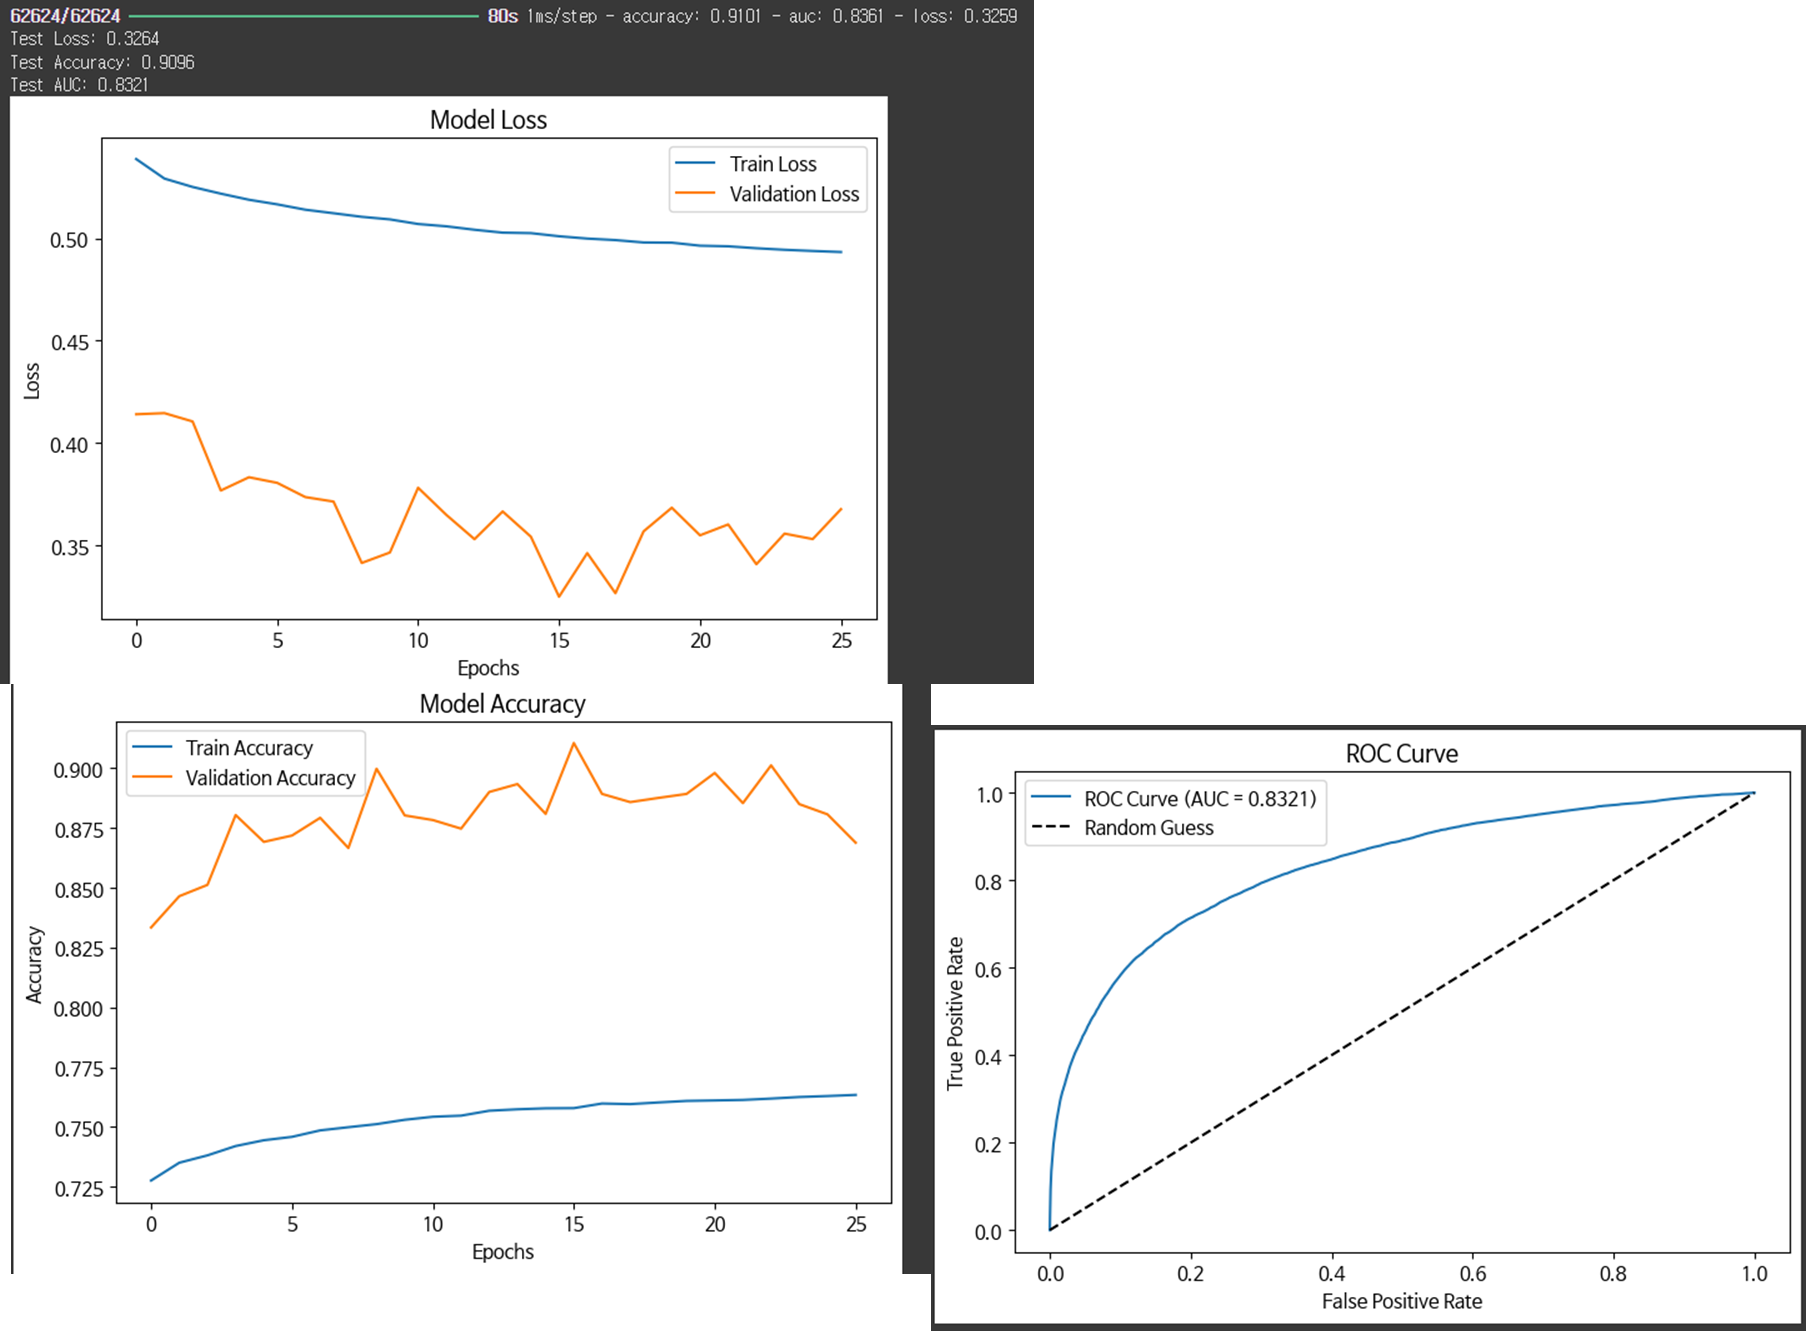

Validation loss를 보면 과적합이 심해보임.

두 번째 학습

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.mixed_precision import set_global_policy
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# GPU 확인 및 혼합 정밀도 설정
# -----------------------------------------------------------
# GPU 활성화 확인
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU Device: ", tf.config.list_physical_devices('GPU'))

# 혼합 정밀도 설정 (A100 GPU 최적화)
set_global_policy('mixed_float16')  # 혼합 정밀도 활성화로 연산 속도 향상

# -----------------------------------------------------------
# 데이터 준비
# -----------------------------------------------------------
# 독립 변수와 타겟 변수 분리
X_train, y_train = train.drop(columns=['churn']), train['churn']
X_val, y_val = val.drop(columns=['churn']), val['churn']
X_test, y_test = test.drop(columns=['churn']), test['churn']

# -----------------------------------------------------------
# MLP 모델 정의
# -----------------------------------------------------------
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],)),  # 입력 크기
    BatchNormalization(),  # 배치 정규화 추가
    LeakyReLU(alpha=0.1),  # ReLU 대신 LeakyReLU 사용
    Dropout(0.5),  # 과적합 방지를 위해 Dropout 비율 증가

    Dense(64),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.4),

    Dense(32),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),

    Dense(1, activation='sigmoid')  # 이진 분류를 위한 sigmoid 출력층
])

# 모델 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # 학습률 조정
    loss='binary_crossentropy',  # 이진 분류 손실 함수
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]  # 정확도와 AUC
)

# -----------------------------------------------------------
# 학습
# -----------------------------------------------------------
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # 조기 종료 조건 조정
    restore_best_weights=True  # 가장 좋은 모델 복원
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # 최대 100 에포크
    batch_size=128,  # 배치 크기 조정 (256 → 128로 감소)
    callbacks=[early_stopping],  # 조기 종료
    verbose=1
)

In [ ]:
# -----------------------------------------------------------
# 테스트 데이터 평가
# -----------------------------------------------------------
test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# -----------------------------------------------------------
# 학습 및 검증 결과 시각화
# -----------------------------------------------------------
import matplotlib.pyplot as plt

# 1. Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 2. Accuracy 시각화
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# -----------------------------------------------------------
# AUC-ROC 곡선 시각화
# -----------------------------------------------------------
from sklearn.metrics import roc_curve, auc

# 예측 확률 계산
y_test_probabilities = model.predict(X_test)

# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(y_test, y_test_probabilities)
roc_auc = auc(fpr, tpr)

# ROC 곡선 시각화
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

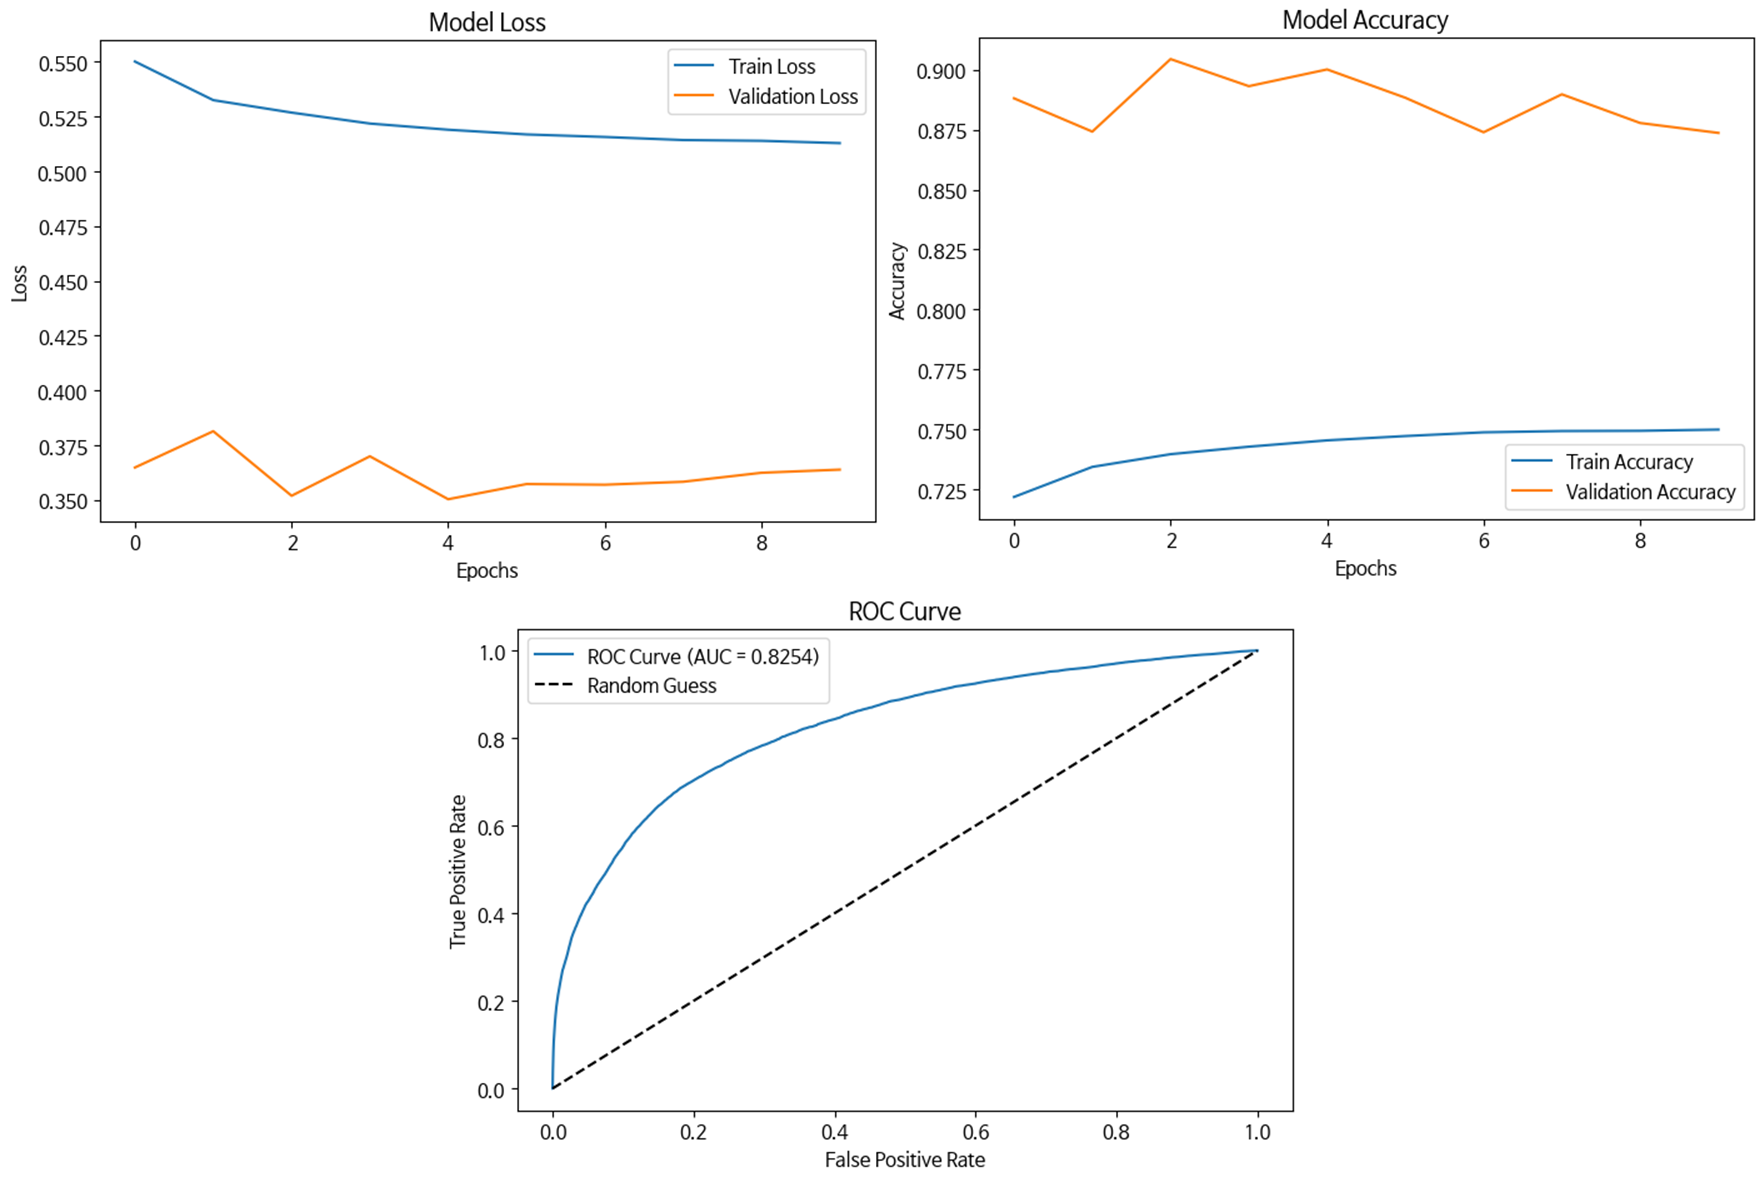
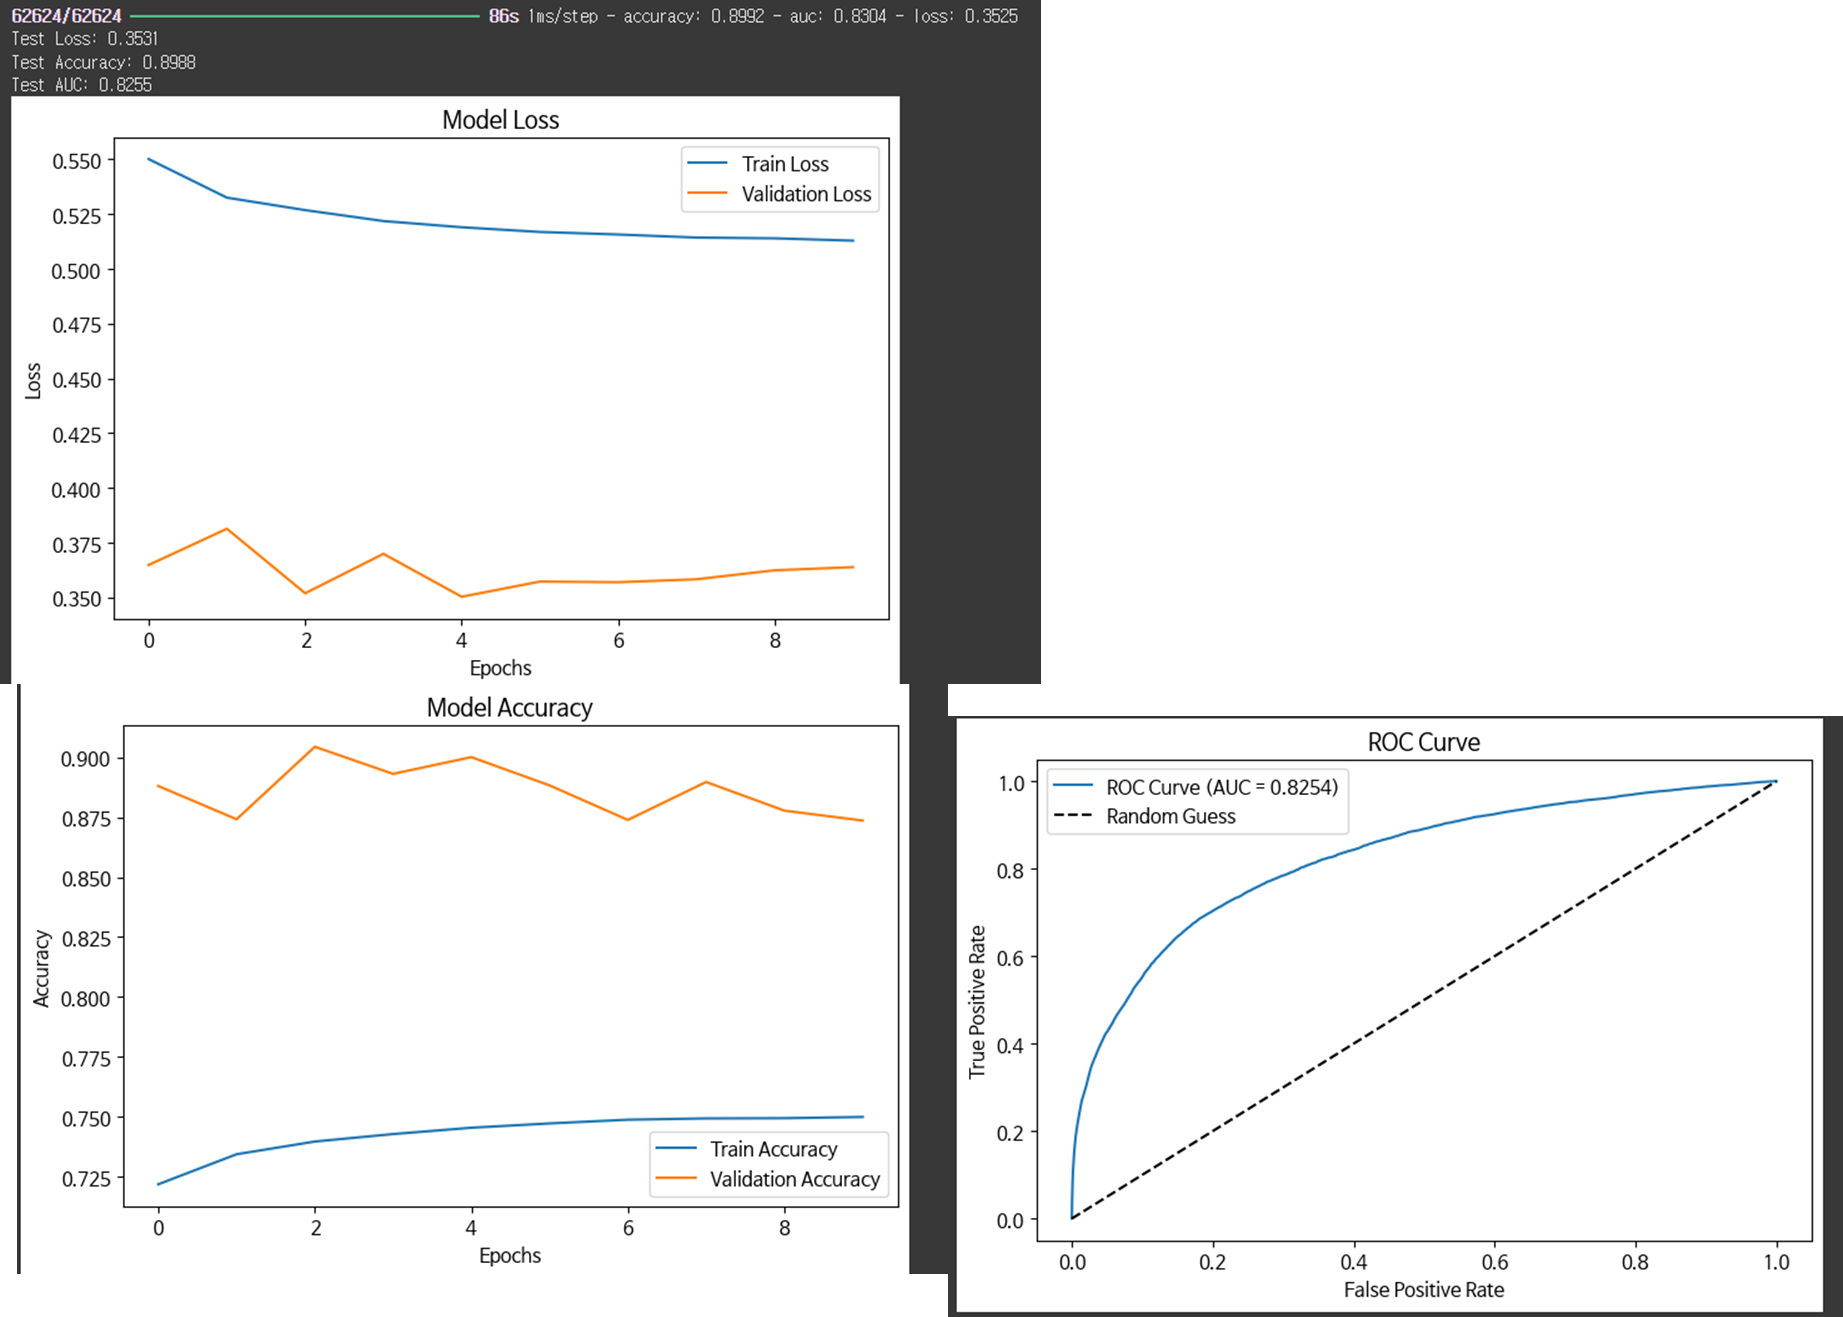

테스트 데이터 평가

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# 테스트 데이터 평가
# -----------------------------------------------------------

# 테스트 데이터 예측 확률
test_probabilities = model.predict(X_test)

# 확률 값을 0.5 기준으로 이진 분류
test_predictions = (test_probabilities > 0.5).astype(int).flatten()

# 정확도 계산
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy:.2f}")

# F1-Score 계산
test_f1 = f1_score(y_test, test_predictions)
print(f"Test F1-Score: {test_f1:.2f}")

# AUC 계산
test_auc = roc_auc_score(y_test, test_probabilities)
print(f"Test AUC: {test_auc:.2f}")

# Classification Report 출력
print("\nClassification Report (Test):")
print(classification_report(y_test, test_predictions))

# Confusion Matrix 시각화
cm_test = confusion_matrix(y_test, test_predictions)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[0, 1])
disp_test.plot(cmap="Blues")
plt.title("Test Confusion Matrix")
plt.show()

# AUC-ROC Curve 시각화
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, test_probabilities)
plt.figure()
plt.plot(fpr_test, tpr_test, label=f"Test ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test ROC Curve")
plt.legend()
plt.show()

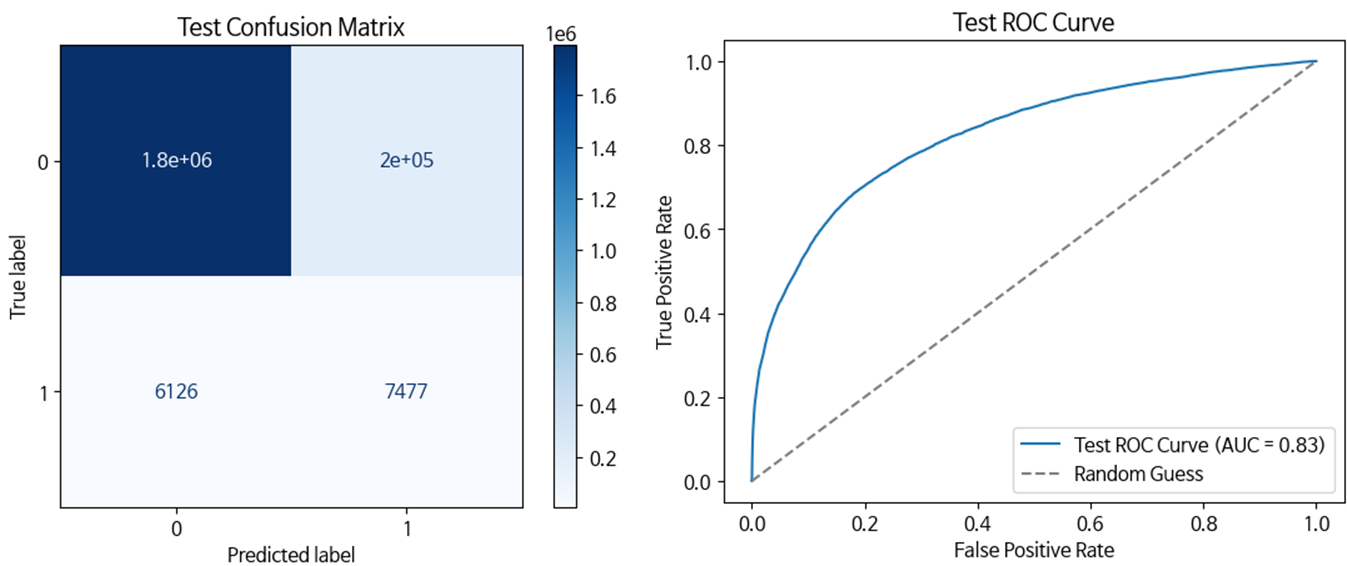
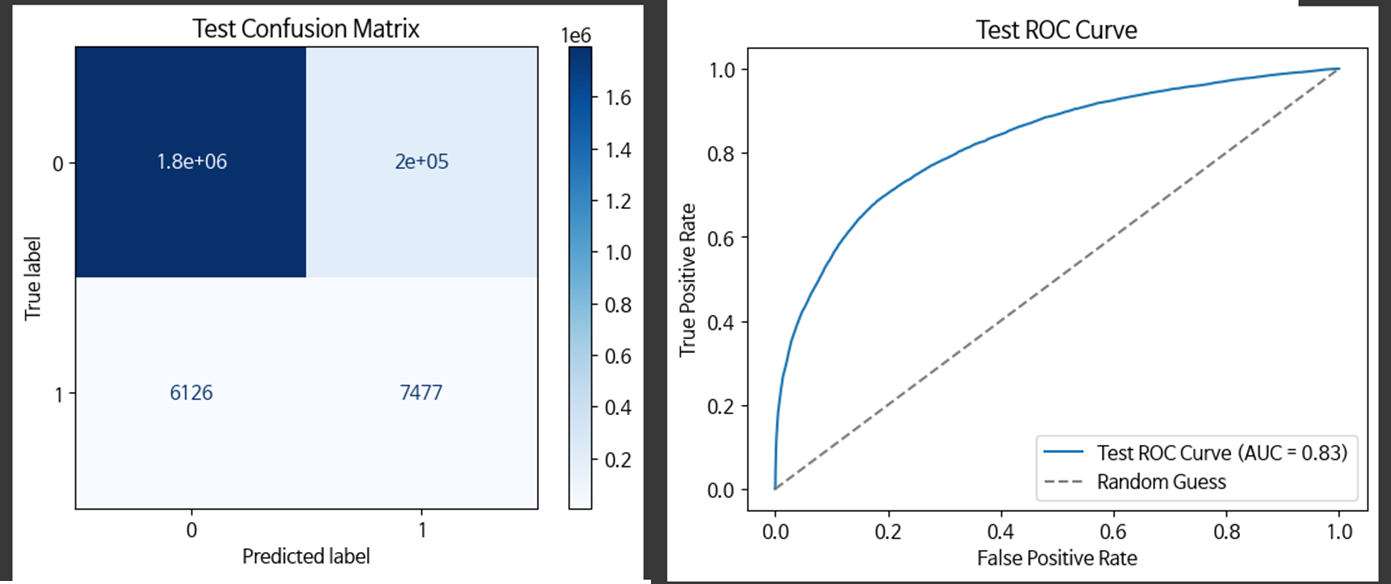

LightGBM보다 성능이 더 좋지 않음. 0일때, 0인 경우를 많이 찾아서 ROC의 값이 0.83으로 높게 나온 것 같음. <br><br>
FN값이 너무 높음.

하이퍼 파라미터 튜닝하고, 모델을 다시 돌려보자.

In [ ]:
import keras_tuner as kt

# 모델 정의 함수
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units_layer1', min_value=64, max_value=256, step=64), activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(hp.Float('dropout_layer1', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(hp.Int('units_layer2', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout_layer2', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[0.0005, 0.001, 0.005])),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

# 튜너 정의
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',  # 최적화 목표
    max_trials=10,  # 최대 실험 횟수
    executions_per_trial=1,  # 각 설정에서 실행 횟수
    directory='my_dir',
    project_name='mlp_tuning'
)

# 튜닝 시작
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=128)

# 최적의 하이퍼파라미터 확인
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

# 최적 하이퍼파라미터로 모델 학습
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=128)

# 최종 모델 평가
final_loss, final_accuracy, final_auc = best_model.evaluate(X_test, y_test)
print(f"Final Test Accuracy: {final_accuracy:.2f}")
print(f"Final Test AUC: {final_auc:.2f}")

In [ ]:
# Best hyperparameters: {'units_layer1': 128, 'dropout_layer1': 0.2, 'units_layer2': 128, 'dropout_layer2': 0.4, 'learning_rate': 0.001}

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# 테스트 데이터 평가
# -----------------------------------------------------------

# 테스트 데이터 예측 확률
test_probabilities = best_model.predict(X_test)

# 확률 값을 0.5 기준으로 이진 분류
test_predictions = (test_probabilities > 0.5).astype(int).flatten()

# 정확도 계산
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy:.2f}")

# F1-Score 계산
test_f1 = f1_score(y_test, test_predictions)
print(f"Test F1-Score: {test_f1:.2f}")

# AUC 계산
test_auc = roc_auc_score(y_test, test_probabilities)
print(f"Test AUC: {test_auc:.2f}")

# Classification Report 출력
print("\nClassification Report (Test):")
print(classification_report(y_test, test_predictions))

# Confusion Matrix 시각화
cm_test = confusion_matrix(y_test, test_predictions)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[0, 1])
disp_test.plot(cmap="Blues")
plt.title("Test Confusion Matrix")
plt.show()

# AUC-ROC Curve 시각화
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, test_probabilities)
plt.figure()
plt.plot(fpr_test, tpr_test, label=f"Test ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test ROC Curve")
plt.legend()
plt.show()

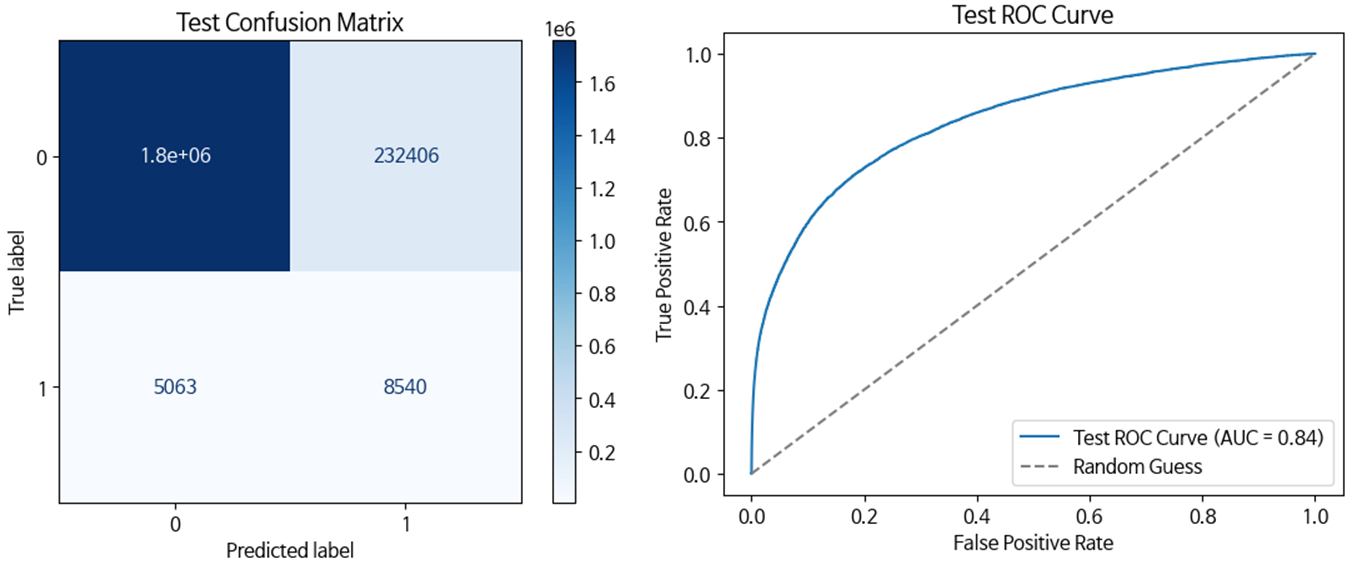

MLP보다는 LightGBM이나 CatBoost가 해당 데이터에서는 더 좋은 성능을 보인다.